In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import time
import optuna

# Set random seeds for reproducibility
RANDOM_SEED = 50
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [2]:
class DiamondPriceMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rate=0.3, use_batch_norm=True, target_mean=None):
        super(DiamondPriceMLP, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, 1))
        self.network = nn.Sequential(*layers)
        
        self._initialize_weights(target_mean)
    
    def _initialize_weights(self, target_mean):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if target_mean is not None:
            nn.init.constant_(self.network[-1].bias, target_mean)
    
    def forward(self, x):
        return self.network(x).squeeze()

In [3]:
# Get the current working directory (for Jupyter Notebooks)
script_dir = os.getcwd()

# Get the parent directory (the "father" folder)
parent_dir = os.path.dirname(script_dir)

# Define the path to the preprocessed data directory relative to the script's location
data_dir = os.path.join(parent_dir, 'data')

# Define the path to the models directory relative to the parent directory of the script's location
models_dir = os.path.join(parent_dir, 'models')

# Create the models directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

In [4]:
# Load the preprocessed data
X_train = np.load(f'{data_dir}/X_train_final.npy')
X_val = np.load(f'{data_dir}/X_val_final.npy')
X_test = np.load(f'{data_dir}/X_test_final.npy')

y_train_log = np.load(f'{data_dir}/y_train_log.npy')  # Log-transformed version!
y_val_log = np.load(f'{data_dir}/y_val_log.npy')
y_test_log = np.load(f'{data_dir}/y_test_log.npy')

def train_model(trial, X_train, y_train, X_val, y_val, device, 
                n_epochs=300, early_stopping_patience=40, early_stopping=False):
    """
    Train model with hyperparameters suggested by Optuna
    
    Returns validation RMSE (lower is better)
    """
    
    # ========================================================================
    # HYPERPARAMETERS TO TUNE
    # ========================================================================
    
    # 1. Architecture
    '''
    n_layers = trial.suggest_int('n_layers', 3, 6)
    hidden_dims = []
    current_dim = trial.suggest_categorical('start_units', [1024, 256, 512])

    for i in range(n_layers):
        # FIX: Suggest a 'shrink' decision (0 = same size, 1 = half size)
        # The choices [0, 1] are now STATIC, so Optuna stays happy.
        should_shrink = trial.suggest_categorical(f'shrink_layer_{i}', [0, 1])
        
        if should_shrink == 1 and current_dim > 64: # Safety floor
            current_dim = current_dim // 2
            
        hidden_dims.append(current_dim)
    '''
    hidden_dims = [512, 256, 256, 128, 128, 64, 32]
    
    # 2. Regularization
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    
    # 3. Learning rate
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    
    # 4. Batch size
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    
    # ========================================================================
    # CREATE MODEL AND OPTIMIZER
    # ========================================================================
    
    model = DiamondPriceMLP(
        input_dim=X_train.shape[1],
        hidden_dims=hidden_dims,
        dropout_rate=dropout_rate,
        use_batch_norm=use_batch_norm,
        target_mean=np.mean(y_train_log)
    ).to(device)
    

    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=weight_decay
    )

    train_criterion = nn.HuberLoss(delta=trial.suggest_float('huber_delta', 0.05, 1.0))
    val_criterion = nn.MSELoss()
    
    # Create dataloaders
    train_dataset = TensorDataset(
        torch.FloatTensor(X_train),
        torch.FloatTensor(y_train)
    )
    val_dataset = TensorDataset(
        torch.FloatTensor(X_val),
        torch.FloatTensor(y_val)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # ========================================================================
    # TRAINING LOOP
    # ========================================================================
    
    best_val_mape = float('inf')
    patience_counter = 0
    
    for epoch in range(n_epochs):
        # Train
        model.train()
        for features, targets in train_loader:
            features = features.to(device)
            targets = targets.to(device)
            
            output = model(features)
            loss = train_criterion(output.view(-1), targets.view(-1))
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # ← Gradient clipping
            
            optimizer.step()
        
        # Validate
        model.eval()
        val_losses = []
        val_real_losses = []
        val_mapes = []        # ← New list to store MAPE values
        
        with torch.no_grad():
            for features, targets in val_loader:
                features = features.to(device)
                targets = targets.to(device)
                
                output = model(features)
                loss = val_criterion(output.view(-1), targets.view(-1))
                val_losses.append(loss.item())

                output_safe = torch.clamp(output, min=0, max=20)  # ← Clamping to avoid overflow
                real_output = torch.expm1(output_safe)      # ← Changed from exp() to expm1()
                real_targets = torch.expm1(targets)    # ← Changed from exp() to expm1()
                real_loss = val_criterion(real_output.view(-1), real_targets.view(-1))
                val_real_losses.append(real_loss.item())   

                abs_percentage_error = torch.abs((real_targets - real_output) / (real_targets + 1e-8))
                batch_mape = torch.mean(abs_percentage_error) * 100
                val_mapes.append(batch_mape.item())  
        
        val_loss = np.mean(val_losses)
        val_real_loss  = np.mean(val_real_losses)
        val_real_rmse = np.sqrt(val_real_loss)
        val_mape = np.mean(val_mapes)  # <--- Average MAPE for the epoch
        
        if val_mape < best_val_mape:
                    best_val_mape = val_mape
                    patience_counter = 0
                    # Optional: Save best model state here
        else:
            patience_counter += 1

        # Report intermediate value for pruning
        trial.report(val_mape, epoch)
        
        if early_stopping and patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Prune unpromising trials
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # ========================================================================
    # FINAL EVALUATION (Real RMSE)
    # ========================================================================
    
    model.eval()
    total_real_mse = 0.0
    total_abs_perc_error = 0.0  # ← Added to track MAPE
    total_samples = 0
    
    with torch.no_grad():
        for features, targets in val_loader:
            features = features.to(device)
            targets = targets.to(device)
            
            # 1. Get model log-predictions
            output_log = model(features).view(-1)
            output_log_safe = torch.clamp(output_log, min=0, max=20)  # ← Clamping to avoid overflow
            targets_log = targets.view(-1)
            
            # 2. Transform BOTH to real prices ($)
            # We do this before the criterion to calculate RMSE in dollars
            output_real = torch.expm1(output_log_safe)
            targets_real = torch.expm1(targets_log)
            
            # 3. Calculate MSE & Absolute Percentage Error
            batch_size = features.size(0)
            
            # MSE (for RMSE)
            batch_mse = val_criterion(output_real, targets_real)
            total_real_mse += batch_mse.item() * batch_size
            
            # MAPE: |(Actual - Predicted) / Actual|
            # We use torch.sum here to get the total error for the batch
            abs_perc_err = torch.abs((targets_real - output_real) / (targets_real + 1e-8))
            total_abs_perc_error += torch.sum(abs_perc_err).item()
            
            # 4. Accumulate samples
            total_samples += batch_size

    # 5. Final RMSE calculation
    final_real_mse = total_real_mse / total_samples
    rmse = np.sqrt(final_real_mse)

    # Calculate final MAPE as a percentage
    mape = (total_abs_perc_error / total_samples) * 100
    
    return mape

In [6]:

def objective(trial):
    """
    Objective function for Optuna to minimize
    """
    
    # Load data
    print(f"\nTrial {trial.number}: Testing hyperparameters...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Train and evaluate
    
    mape = train_model(trial, X_train, y_train_log, X_val, y_val_log, device, early_stopping=False)
    
    # Check for invalid values
    if np.isnan(mape) or np.isinf(mape):
        rmse = 1000 # Large penalty
    
  
    print(f"  → Validation MAPE: ${mape:,.0f}")
    
    return mape

In [7]:
# now we can run the experiment
storage_name = "sqlite:///diamond_study.db"
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    study_name="diamond-mlp", 
    storage=storage_name, 
    direction="minimize",
    load_if_exists=True  # Crucial for restarting
)
study.optimize(objective, n_trials=100, show_progress_bar=True, catch=(Exception,))

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2026-01-17 14:42:35,284] A new study created in RDB with name: diamond-mlp


  0%|          | 0/100 [00:00<?, ?it/s]


Trial 0: Testing hyperparameters...
  → Validation MAPE: $11
[I 2026-01-17 14:51:55,930] Trial 0 finished with value: 11.398057724438111 and parameters: {'dropout_rate': 0.08285785120200967, 'weight_decay': 1.2571392326591187e-06, 'use_batch_norm': True, 'learning_rate': 0.0012693276153465524, 'batch_size': 256, 'huber_delta': 0.48810830589323606}. Best is trial 0 with value: 11.398057724438111.

Trial 1: Testing hyperparameters...
  → Validation MAPE: $12
[I 2026-01-17 14:58:09,624] Trial 1 finished with value: 12.197589788876213 and parameters: {'dropout_rate': 0.2644303418075645, 'weight_decay': 8.3781775950335e-05, 'use_batch_norm': True, 'learning_rate': 7.006693980604081e-05, 'batch_size': 512, 'huber_delta': 0.22477273362206307}. Best is trial 0 with value: 11.398057724438111.

Trial 2: Testing hyperparameters...
  → Validation MAPE: $15
[I 2026-01-17 15:13:05,050] Trial 2 finished with value: 14.82023297378542 and parameters: {'dropout_rate': 0.3815380673483289, 'weight_decay'

In [10]:
# ========================================================================
# FINAL TRAINING WITH BEST PARAMETERS
# ========================================================================

print("\n--- Training Final Model with Best Parameters ---")

# 1. Get best params from study
best_params = study.best_params

# Note: In your code, hidden_dims was fixed. 
# If you used the commented-out dynamic architecture, you'd reconstruct it here.
final_hidden_dims = [512, 256, 256, 128, 128, 64, 32] 

# 2. Re-initialize Model
final_model = DiamondPriceMLP(
    input_dim=X_train.shape[1],
    hidden_dims=final_hidden_dims,
    dropout_rate=best_params['dropout_rate'],
    use_batch_norm=best_params['use_batch_norm'],
    target_mean=np.mean(y_train_log)
).to(device)

# 3. Re-initialize Optimizer and Loss
optimizer = torch.optim.Adam(
    final_model.parameters(), 
    lr=best_params['learning_rate'], 
    weight_decay=best_params['weight_decay']
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=40
)

# Use the best Huber delta found
criterion = nn.HuberLoss(delta=best_params['huber_delta'])
val_criterion = nn.MSELoss()

# 4. Prepare Dataloaders
train_loader = DataLoader(
    TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train_log)), 
    batch_size=best_params['batch_size'], 
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val_log)), 
    batch_size=best_params['batch_size'], 
    shuffle=False
)

# 5. Training Loop
num_epochs = 500  # You might want to train longer for the final model
best_val_loss = float('inf')
loss_history = []

for epoch in range(num_epochs):
    final_model.train()
    train_losses = []
    for features, targets in train_loader:
        features, targets = features.to(device), targets.to(device)
        
        optimizer.zero_grad()
        output = final_model(features)
        loss = criterion(output.view(-1), targets.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(final_model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    final_model.eval()
    val_losses = []
    val_real_losses = []  # ← Better name
    val_mapes = []        # ← New list to store MAPE values
    with torch.no_grad():
        for features, targets in val_loader:
            features = features.to(device)
            targets = targets.to(device)
            output = final_model(features)

            loss = val_criterion(output.view(-1), targets.view(-1))
            val_losses.append(loss.item())

            real_output = torch.expm1(output)      # ← Changed from exp() to expm1()
            real_targets = torch.expm1(targets)    # ← Changed from exp() to expm1()
            real_loss = val_criterion(real_output.view(-1), real_targets.view(-1))
            val_real_losses.append(real_loss.item())

            abs_percentage_error = torch.abs((real_targets - real_output) / (real_targets + 1e-8))
            batch_mape = torch.mean(abs_percentage_error) * 100
            val_mapes.append(batch_mape.item())            
    
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        val_real_loss  = np.mean(val_real_losses)
        val_real_rmse = np.sqrt(val_real_loss)
        val_mape = np.mean(val_mapes)  # <--- Average MAPE for the epoch
        scheduler.step(val_real_rmse)
        loss_history.append((train_loss, val_loss, val_real_loss))

    if epoch % 5 == 0:
        print(f'Epoch {epoch}: Train Loss = {train_loss:.6f}, '
              f'Val Loss (log) = {val_loss:.6f}, '
              f'Val RMSE (real $) = ${val_real_rmse:,.2f}, '
              f'Val MAPE = {val_mape:.2f}%, '
              f'LR={scheduler.get_last_lr()}')
    




--- Training Final Model with Best Parameters ---
Epoch 0: Train Loss = 0.011667, Val Loss (log) = 0.040227, Val RMSE (real $) = $2,576.42, Val MAPE = 11.71%, LR=[0.00013905679555526666]
Epoch 5: Train Loss = 0.006606, Val Loss (log) = 0.036649, Val RMSE (real $) = $2,420.58, Val MAPE = 11.21%, LR=[0.00013905679555526666]
Epoch 10: Train Loss = 0.006293, Val Loss (log) = 0.035507, Val RMSE (real $) = $2,336.04, Val MAPE = 10.91%, LR=[0.00013905679555526666]
Epoch 15: Train Loss = 0.006190, Val Loss (log) = 0.034107, Val RMSE (real $) = $2,303.89, Val MAPE = 10.71%, LR=[0.00013905679555526666]
Epoch 20: Train Loss = 0.006068, Val Loss (log) = 0.033905, Val RMSE (real $) = $2,272.88, Val MAPE = 10.43%, LR=[0.00013905679555526666]
Epoch 25: Train Loss = 0.006052, Val Loss (log) = 0.034024, Val RMSE (real $) = $2,264.31, Val MAPE = 10.20%, LR=[0.00013905679555526666]
Epoch 30: Train Loss = 0.005988, Val Loss (log) = 0.034856, Val RMSE (real $) = $2,295.00, Val MAPE = 10.18%, LR=[0.0001390

In [11]:
# ========================================================================
# SAVE THE MODEL
# ========================================================================

model_save_path = os.path.join(models_dir, 'best_diamond_mlp_model.pth')

# Prepare metadata to save alongside weights
model_info = {
    'model_state_dict': final_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'hyperparameters': {
        'input_dim': X_train.shape[1],
        'hidden_dims': final_hidden_dims,
        'dropout_rate': best_params['dropout_rate'],
        'use_batch_norm': best_params['use_batch_norm'],
        'target_mean': np.mean(y_train_log)
    },
    'best_mape': study.best_value
}

torch.save(model_info, model_save_path)
print(f"\nModel saved successfully to: {model_save_path}")


Model saved successfully to: /home/amit.ru/Documents/DL-Project/src/largest_diamond_dataset/models/best_diamond_mlp_model.pth


In [7]:
# 1. Define model architecture (must match the class above)
# 2. Load the saved file
checkpoint = torch.load(f'{models_dir}/best_diamond_mlp_model.pth', weights_only=False)

# 3. Reconstruct model using saved hyperparams
loaded_model = DiamondPriceMLP(**checkpoint['hyperparameters'])
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()

print("Model loaded and ready for inference!")

Model loaded and ready for inference!


In [8]:
# 1. Convert data to tensors
X_test = torch.tensor(X_test, dtype=torch.float32)

# 2. Get predictions from the loaded MLP
loaded_model.eval()
with torch.no_grad():
    y_test_pred_log = loaded_model(X_test).numpy().flatten()

# 3. Convert predictions back to original scale
y_test_pred = np.expm1(y_test_pred_log)

Plot saved to: results/mlp_actual_vs_predicted.png


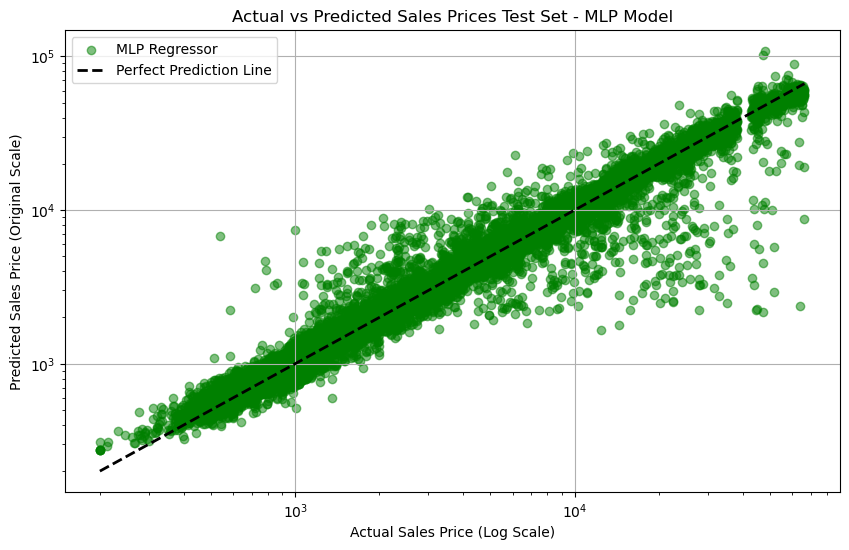

In [16]:
# 1. Create the 'result' folder if it doesn't exist
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print(f"Folder '{results_dir}' created.")

# 2. Your plotting code
plt.figure(figsize=(10, 6))
plt.scatter(np.expm1(y_test_log), y_test_pred, alpha=0.5, color='green', label='MLP Regressor')
plt.plot([np.expm1(y_test_log.min()), np.expm1(y_test_log.max())], 
         [np.expm1(y_test_log.min()), np.expm1(y_test_log.max())], 'k--', lw=2, label='Perfect Prediction Line')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Sales Price (Log Scale)')
plt.ylabel('Predicted Sales Price (Original Scale)')
plt.title('Actual vs Predicted Sales Prices Test Set - MLP Model')
plt.legend()
plt.grid(True)

# 3. Save the plot BEFORE plt.show()
file_path = os.path.join(results_dir, 'mlp_actual_vs_predicted.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to: {file_path}")

# 4. Show the plot
plt.show()

In [13]:
# 1. Get the actual values in original scale
y_test_actual = np.expm1(y_test_log)

# 2. Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
r2 = r2_score(y_test_actual, y_test_pred)
mape = mean_absolute_percentage_error(y_test_actual, y_test_pred)

# 3. Print the results
print("--- MLP Model Performance (Test Set) ---")
print(f"RMSE: ${rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape * 100:.2f}%")

--- MLP Model Performance (Test Set) ---
RMSE: $2182.57
R² Score: 0.9312
MAPE: 10.00%
